In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

import sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.models import load_model

os.getcwd()

'c:\\Users\\johnc\\Documents\\Python Scripts\\ocean-depth-characterization\\preliminary_models'

In [2]:
# import dataframe
df_norm_piv = pd.read_csv('../data/final_norm_set.csv')
cluster_indeces = ['HCB', 'PDCM', 'EQ', 'LCB', 'AR', 'SDCM']

# split data
full_train = df_norm_piv[df_norm_piv.train == 1]
full_test = df_norm_piv[df_norm_piv.train == 0]

# narrow down the features we want
X_train = full_train[['latitude', 'longitude', 'date_doy_rad', 'sat_chl_month', 'sat_sst_month', 'sat_pic_month', 'sat_aph_443_month']]
X_test = full_test[['latitude', 'longitude', 'date_doy_rad', 'sat_chl_month', 'sat_sst_month', 'sat_pic_month', 'sat_aph_443_month']]
# get labels
label_bins = [1, 2, 3, 4]
Y_train = full_train[['norm_' + str(i) for i in label_bins]]
Y_test = full_test[['norm_' + str(i) for i in label_bins]]

input_dim = X_train.shape[1]
output_dim = Y_train.shape[1]

#scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# set up the model
nn_model = Sequential()

nn_model.add(Dense(108, input_dim=input_dim, activation='relu'))
nn_model.add(Dropout(0.3))
nn_model.add(Dense(28, activation='relu'))
nn_model.add(Dropout(0.3))
nn_model.add(Dense(output_dim))

nn_model.compile(loss='mse', optimizer='adam')

# fit the model
nn_history = nn_model.fit(X_train, Y_train, epochs=15, batch_size=32, verbose=1)

# check our MSE on the 4 prediction points
preds = nn_model.predict(X_test)
actuals = Y_test.to_numpy()
mean_squared_error(actuals, preds)

Epoch 1/15
1066/1066 [==============================] - 11s 4ms/step - loss: 0.1374
Epoch 2/15
1066/1066 [==============================] - 5s 4ms/step - loss: 0.1202
Epoch 3/15
1066/1066 [==============================] - 5s 5ms/step - loss: 0.1132
Epoch 4/15
1066/1066 [==============================] - 5s 5ms/step - loss: 0.1130
Epoch 5/15
1066/1066 [==============================] - 5s 5ms/step - loss: 0.1114
Epoch 6/15
1066/1066 [==============================] - 5s 4ms/step - loss: 0.1094
Epoch 7/15
1066/1066 [==============================] - 5s 4ms/step - loss: 0.1092
Epoch 8/15
1066/1066 [==============================] - 4s 4ms/step - loss: 0.1090
Epoch 9/15
1066/1066 [==============================] - 5s 4ms/step - loss: 0.1096
Epoch 10/15
1066/1066 [==============================] - 5s 4ms/step - loss: 0.1079
Epoch 11/15
1066/1066 [==============================] - 4s 4ms/step - loss: 0.1050
Epoch 12/15
1066/1066 [==============================] - 4s 4ms/step - loss: 0.1055


0.10523121886742973

WOW NORMALIZED CLUSTERS WOOHOO


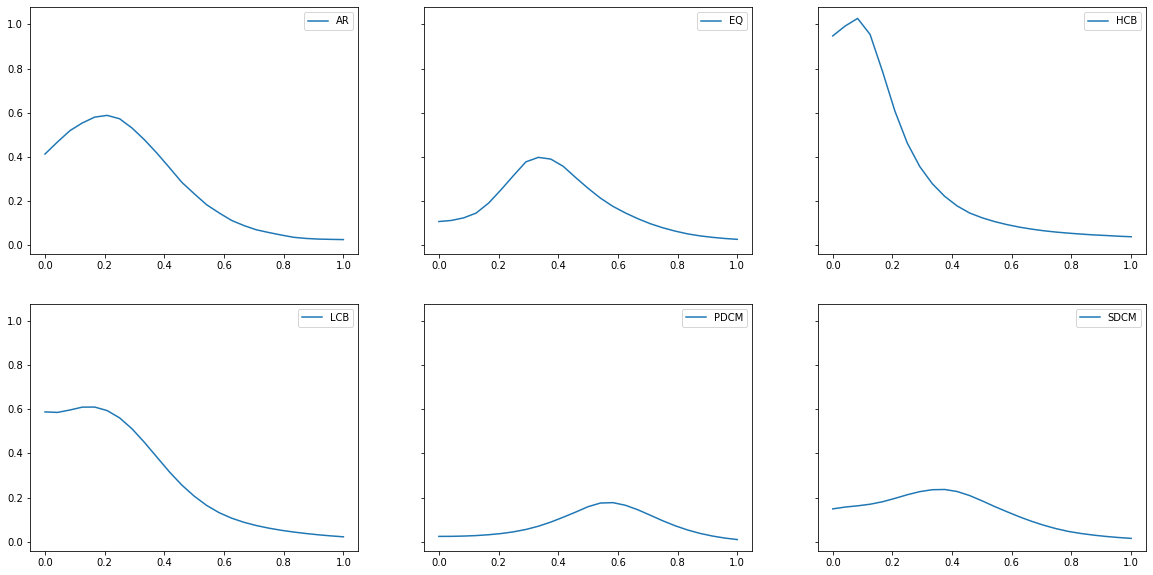

In [3]:
# create our normalized cluster distributions
df_known_dist = pd.read_csv('../data/cluster_chla_distribution.csv')

def build_normalized_cluster_centers(df_known_dist, n_points=25, plot_clusters=False, return_centers=True):
    out = pd.cut(df_known_dist.PRES, bins=25, labels=[i for i in range(25)])
    df_known_dist['depth_bin'] = out
    df_known_dist_binned = df_known_dist[['cluster', 'depth_bin', 'CHLA']] \
        .groupby(['cluster', 'depth_bin']).mean().reset_index().dropna()
    xnew = np.linspace(0, 1, n_points)
    raw_dists = list()
    norm_cluster_depths = {
        'AR': 14,
        'EQ': 18,
        'HCB': 23,
        'LCB': 23,
        'PDCM': 23,
        'SDCM': 20
    }
    if plot_clusters:
        fig, ax = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
    for i, c in enumerate(np.unique(df_known_dist_binned.cluster)):
        ydata = df_known_dist_binned[df_known_dist_binned.cluster == c]['CHLA'].to_numpy()[:norm_cluster_depths[c]]
        xdata = np.linspace(0, 1, len(ydata))
        fc = interp1d(xdata, ydata, kind='slinear')
        ynew = fc(xnew)
        raw_dists.append(ynew)
        if plot_clusters:
            ax[i // 3, i % 3].plot(xnew, ynew, label=c)
            ax[i //3, i % 3].legend()
    if return_centers:
        return np.array(raw_dists)

print('WOW NORMALIZED CLUSTERS WOOHOO')
centers = build_normalized_cluster_centers(df_known_dist, plot_clusters=True)

In [4]:
# build kmeans for easy cluster prediction
kmeans = KMeans(n_clusters=6)
kmeans.fit(centers)

d:\langs\anaconda_dist\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=6)

In [5]:
# make prediction interpolations to match the xdata length in our kmeans algorithm
def interpolate_predictions(preds, n_points=25):
    '''
    interpolate our predictions so we can be on the same
    number line as our normalized clusters. this allows us to
    do kmeans predictions to help our predictions!
    '''
    interp_preds = list()
    xold = np.linspace(0, 1, 4)
    xnew = np.linspace(0, 1, n_points)
    for p in preds:
        fp = interp1d(xold, p, kind='slinear')
        pnew = fp(xnew)
        interp_preds.append(pnew)
    return pd.DataFrame(np.array(interp_preds), columns=['intpred_' + str(i) for i in range(n_points)])

interpd_preds = interpolate_predictions(preds)

In [6]:
def mix_vals(x1, x2, perc_x1=0.5):
    perc_x2 = 1-perc_x1
    return (x1*perc_x1) + (x2*perc_x2)

In [11]:
# using our interpolated predictions and closest kmeans cluster
# we can make our final predictions
def build_final_predictions(interpd_preds, kmeans, mixture=0.2, n_points=25):
    kmeans_preds = kmeans.predict(interpd_preds)
    centers = kmeans.cluster_centers_
    final_predictions = list()
    for i, int_p in interpd_preds.iterrows():
        closest_center = centers[kmeans_preds[i], :]
        prediction = mix_vals(closest_center, int_p, perc_x1=mixture)
        final_predictions.append(prediction)
    return pd.DataFrame(np.array(final_predictions), columns=['fin_pred_' + str(i) for i in range(n_points)])

final_predictions = build_final_predictions(interpd_preds, kmeans, mixture=0.2).set_index(full_test.index)

d:\langs\anaconda_dist\envs\tf-gpu\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [12]:
final_predictions

,fin_pred_0,fin_pred_1,fin_pred_2,fin_pred_3,fin_pred_4,fin_pred_5,fin_pred_6,fin_pred_7,fin_pred_8,fin_pred_9,...,fin_pred_15,fin_pred_16,fin_pred_17,fin_pred_18,fin_pred_19,fin_pred_20,fin_pred_21,fin_pred_22,fin_pred_23,fin_pred_24
0,0.932930,0.901061,0.871836,0.843056,0.811716,0.777133,0.739135,0.697823,0.654113,0.581899,...,0.173340,0.110671,0.097908,0.085724,0.073962,0.062547,0.051380,0.040382,0.029582,0.018918
13,1.023277,1.001432,0.977451,0.932145,0.867890,0.800988,0.741116,0.689136,0.642880,0.569725,...,0.171925,0.108425,0.096945,0.085769,0.074838,0.064028,0.053319,0.042806,0.032192,0.021748
22,0.894928,0.868928,0.845574,0.822664,0.797194,0.768481,0.736355,0.700913,0.663073,0.590176,...,0.177518,0.114165,0.100827,0.088067,0.075731,0.063740,0.051998,0.040425,0.029050,0.017810
35,0.914823,0.888316,0.864455,0.841038,0.815060,0.785840,0.753206,0.717257,0.678909,0.604589,...,0.183391,0.118615,0.104719,0.091401,0.078507,0.065958,0.053658,0.041527,0.029594,0.017796
39,0.749600,0.737145,0.727335,0.717970,0.706044,0.690875,0.672292,0.650395,0.626098,0.557624,...,0.171497,0.112567,0.099195,0.086402,0.074033,0.062008,0.050233,0.038627,0.027219,0.015945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42319,0.411205,0.429504,0.447210,0.461649,0.474411,0.483398,0.487792,0.486828,0.483607,0.435043,...,0.155146,0.113959,0.099240,0.085883,0.072746,0.059798,0.047882,0.036423,0.025282,0.014199
42327,0.395062,0.409076,0.422495,0.432648,0.441124,0.445824,0.445932,0.440681,0.433174,0.389567,...,0.139414,0.103185,0.089956,0.078090,0.066444,0.054987,0.044561,0.034593,0.024943,0.015351
42331,0.406111,0.419048,0.431390,0.440466,0.447865,0.451489,0.450520,0.444192,0.435608,0.391493,...,0.138288,0.101550,0.088539,0.076891,0.065462,0.054222,0.044014,0.034263,0.024831,0.015456
42334,0.377551,0.393711,0.409278,0.421578,0.432201,0.439048,0.441303,0.438199,0.432839,0.389569,...,0.141434,0.105541,0.092025,0.079870,0.067936,0.056191,0.045476,0.035220,0.025282,0.015401


In [13]:
# need to get all normalized values to compare to predictions
full_test

,float,cycleNumber,latitude,longitude,date_doy_rad,sat_chl_month,sat_sst_month,sat_par_month,sat_pic_month,sat_aph_443_month,...,depth_bin_98,max_depth,train,cluster,max_bin,norm_1,norm_2,norm_3,norm_4,cluster_val
0,1902303,1,49.236,-14.742,2.167505,0.435093,12.451869,39.556000,0.000184,0.0419,...,0.006024,232,0,HCB,24,0.704058,0.684214,0.079771,0.017237,0
13,1902303,14,48.071,-15.022,2.373934,0.489537,12.545573,43.624001,0.000062,0.0305,...,0.005314,150,0,HCB,16,0.897892,0.982076,0.047419,0.013270,0
22,1902303,23,47.512,-14.518,2.528756,0.455152,12.551631,42.734001,0.000016,0.0269,...,0.007528,140,0,HCB,15,1.105843,0.483426,0.036941,0.012427,0
35,1902303,38,46.467,-14.528,2.735185,0.379446,16.223672,47.417999,0.000236,0.0263,...,0.007174,136,0,HCB,14,0.709305,0.421599,0.043254,0.008991,0
39,1902303,42,46.495,-14.965,2.941614,0.407820,15.587559,46.472000,0.000016,0.0233,...,0.005134,104,0,HCB,11,0.722423,1.344044,0.099630,0.012932,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42319,7900589,36,55.980,-46.305,5.126322,0.344542,7.610095,10.013996,0.000012,0.0342,...,-0.000005,124,0,HCB,13,0.489100,0.489100,0.113302,0.009858,0
42327,7901001,4,17.080,-24.424,1.169765,0.402191,21.767555,49.087997,0.000010,0.0280,...,0.000201,126,0,EQ,13,0.182500,0.182500,0.153279,0.003488,2
42331,7901001,8,16.898,-24.381,1.307384,0.450276,21.822344,47.872002,0.000010,0.0309,...,0.000020,149,0,EQ,15,0.306600,0.306916,0.079549,0.004331,2
42334,7901001,11,17.131,-24.170,1.410599,0.390988,21.762587,49.129997,0.000010,0.0213,...,-0.000818,145,0,EQ,15,0.186150,0.158747,0.043956,0.002762,2
